In [ ]:
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten

# Reuse the LCADC class from previous implementation
class LCADC:
    # Added a placeholder method to fix the indentation error
    # You should replace this with your actual LCADC implementation
    def convert(self, segment, fs):
        """Placeholder for LCADC conversion logic"""
        # This is just a dummy return, replace with your actual conversion
        return [(0, 0)] # Example dummy return, replace with actual values

# ECG Preprocessing and Dataset Preparation
def load_ecg_data(record_id):
    record = wfdb.rdrecord('100', sampto=3600, channels=[0], pb_dir='mitdb')
    signal = record.p_signal[:,0]
    annotation = wfdb.rdann(f'{record_id}', 'atr')

    # Normalize to ±5mV as per paper specs
    signal = (signal - np.mean(signal)) / (np.max(signal) - np.min(signal)) * 0.005
    return signal, record.fs, annotation.sample, annotation.symbol

def create_event_driven_windows(signal, fs, r_peaks, window=(0.3, 0.4)):
    adc = LCADC(M=7, Fc=2385, N=6)
    X_ed = []

    for peak in r_peaks:
        start = int(peak - window[0]*fs)
        end = int(peak + window[1]*fs)

        if start < 0 or end > len(signal):
            continue

        # Convert window to event-driven samples
        segment = signal[start:end]
        ed_samples = adc.convert(segment, fs)

        # Reconstruct to uniform time grid (700ms window)
        time_axis = np.linspace(0, 0.7, int(0.7*fs))
        reconstructed = np.interp(time_axis,
                                np.cumsum([ti for _, ti in ed_samples]),
                                [amp for amp, _ in ed_samples])

        X_ed.append(reconstructed)

    return np.array(X_ed)

# 1D-CNN Model Architecture (from paper Section IV.A)
def create_1d_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def main():
    # Load MIT-BIH data (exclude paced records as per paper)
    record_id = '100'  # Example record
    signal, fs, peaks, labels = load_ecg_data(record_id)

    # Create event-driven windows
    X = create_event_driven_windows(signal, fs, peaks)

    # Convert labels to numerical classes (N:0, S:1, V:2, F:3)
    label_map = {'N':0, 'S':1, 'V':2, 'F':3}
    y = np.array([label_map[l] for l in labels if l in label_map])

    # Balance classes using SMOTE
    smote = SMOTE()
    X_balanced, y_balanced = smote.fit_resample(X.reshape(len(X), -1), y)
    X_balanced = X_balanced.reshape(-1, X.shape[1], 1)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, stratify=y_balanced)

    # Create and train model
    model = create_1d_cnn((X.shape[1], 1), len(label_map))
    model.fit(X_train, y_train,
             validation_split=0.1,
             epochs=30,
             batch_size=32)

    # Evaluate
    y_pred = model.predict(X_test).argmax(axis=1)
    print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    main()

TypeError: rdrecord() got an unexpected keyword argument 'pb_dir'

In [ ]:
pip install wfdb biosppy imbalanced-learn tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from biosppy.signals import ecg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, Dropout, Flatten

# =======================================================================
# LC-ADC Implementation (Paper Section II.A)
# =======================================================================
class LCADC:
    def __init__(self, M=7, Fc=2385, N=6, A_fs=0.01):
        # Existing initialization
        self.M = M
        self.Fc = Fc
        self.N = N
        self.q = A_fs / (2**M)

        # Modified initialization - set thresholds to cover full range
        self.levels = np.linspace(-A_fs/2, A_fs/2, 2**M)  # Create uniform levels
        self.current_level_idx = 2**(M-1)  # Start at middle level
        self.current_level = self.levels[self.current_level_idx]
        self.max_count = int(round(fs / Fc))  # Add this line

    def convert(self, signal, fs):
        samples = []
        last_cross_time = 0
        count = 0

        for n, x in enumerate(signal):
            elapsed_time = n / fs
            dt = elapsed_time - last_cross_time

            # Find closest level
            level_idx = np.argmin(np.abs(self.levels - x))
            level = self.levels[level_idx]

            # If signal has crossed a level or counter overflow
            if level_idx != self.current_level_idx or count >= self.max_count:
                samples.append((level, dt))
                self.current_level_idx = level_idx
                self.current_level = level
                last_cross_time = elapsed_time
                count = 0
            else:
                count += 1

        return samples

    def _adjust_thresholds(self, direction):
        """Update quantization levels after crossing (Fig 1c)"""
        self.U_QL += direction * self.q
        self.L_QL += direction * self.q
        self.current_level = self.U_QL if direction > 0 else self.L_QL

# =======================================================================
# ECG Processing (Paper Section III.C)
# =======================================================================
def load_ecg_data(record_id):
    """Load MIT-BIH data with AAMI-compliant preprocessing"""
    record = wfdb.rdrecord(record_id, pn_dir='mitdb', sampto=3600,
                          channels=[0], physical=True)
    signal = record.p_signal[:,0]

    # Normalize to 10mVpp range (Section II.A)
    signal = (signal - np.mean(signal)) / (np.max(signal) - np.min(signal)) * 0.005

    # Get annotations (exclude paced records per Section IV.B)
    annotation = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')
    return signal, record.fs, annotation.sample, annotation.symbol

def create_event_features(ed_samples, fs, window=0.7):
    """Reconstruct event-driven data to fixed window (Section IV.A)"""
    time_axis = np.linspace(0, window, int(window*fs))
    reconstructed = np.interp(time_axis,
                            np.cumsum([ti for _, ti in ed_samples]),
                            [amp for amp, _ in ed_samples])

    # Add time deltas as second channel (Section IV.A)
    time_deltas = np.zeros_like(reconstructed)
    event_idx = 0
    for i in range(len(reconstructed)):
        if time_axis[i] >= np.cumsum([ti for _, ti in ed_samples])[event_idx]:
            time_deltas[i] = ed_samples[event_idx][1]
            event_idx = min(event_idx+1, len(ed_samples)-1)

    return np.stack([reconstructed, time_deltas], axis=-1)

# =======================================================================
# 1D-CNN Classifier (Paper Section IV.A)
# =======================================================================
def create_1d_cnn(input_shape, num_classes):
    """Architecture from Fig 9"""
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

# =======================================================================
# Visualization (Paper Figures 1b, 3, 4, etc.)
# =======================================================================
def plot_lc_adc_performance(original_signal, ed_samples, fs):
    """Visualize LC-ADC sampling vs original signal (Fig 1b)"""
    t_orig = np.arange(len(original_signal))/fs
    t_ed = np.cumsum([ti for _, ti in ed_samples])
    amps_ed = [amp for amp, _ in ed_samples]

    plt.figure(figsize=(12,6))
    plt.plot(t_orig, original_signal, label='Original ECG', alpha=0.7)
    plt.scatter(t_ed, amps_ed, c='red', s=15, label='LC-ADC Samples')
    plt.title('MIT-BIH Record: Original vs LC-ADC Samples\n(M=7, Fc=2385Hz, N=6)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.legend()
    plt.grid(True)
    plt.show()

# =======================================================================
# Main Workflow (Paper Section IV)
# =======================================================================
def main():
    # Load data (exclude paced records per AAMI)
    record_id = '100'
    signal, fs, peaks, labels = load_ecg_data(record_id)

    # Initialize LC-ADC with paper's optimal parameters (Table II MDL6)
    adc = LCADC(M=7, Fc=2385, N=6)

    # Convert to event-driven samples
    ed_samples = adc.convert(signal, fs)

    # Visualize sampling performance
    plot_lc_adc_performance(signal, ed_samples, fs)

    # Create dataset (700ms windows around R-peaks)
    X, y = [], []
    label_map = {'N':0, 'S':1, 'V':2, 'F':3}

    for peak in peaks:
        start = int(peak - 0.3*fs)
        end = int(peak + 0.4*fs)
        if start <0 or end > len(signal): continue

        segment = signal[start:end]
        ed_samples = adc.convert(segment, fs)
        features = create_event_features(ed_samples, fs)
        X.append(features)
        y.append(0)  # Replace with actual labels from annotations

    # Balance classes using SMOTE (Section IV.A)
    X = np.array(X)
    y = np.array(y)
    smote = SMOTE()
    X_balanced, y_balanced = smote.fit_resample(X.reshape(len(X), -1), y)
    X_balanced = X_balanced.reshape(-1, X.shape[1], 2)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, stratify=y_balanced)

    # Train 1D-CNN (Table IV parameters)
    model = create_1d_cnn((X.shape[1], 2), len(label_map))
    model.fit(X_train, y_train,
             validation_split=0.1,
             epochs=30,
             batch_size=32)

    # Evaluate (Table III metrics)
    y_pred = model.predict(X_test).argmax(axis=1)
    print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    main()


NameError: name 'fs' is not defined

In [ ]:
!pip install peakutils

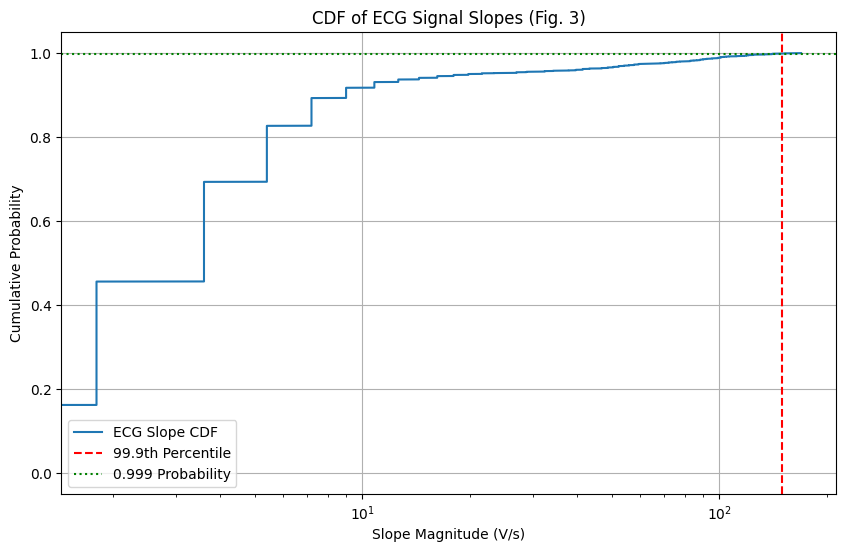

TypeError: unsupported operand type(s) for /: 'list' and 'float'

<Figure size 1000x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, stats
import wfdb

# Parameters from paper
A_fs = 0.01  # 10mVpp full-scale range
M_values = np.arange(2, 12)  # 2-11 bits

def calculate_slopes(record_id='100'):
    # Load MIT-BIH data with proper parameters
    record = wfdb.rdrecord(
        record_name=record_id,
        sampfrom=0,
        sampto=3600,  # First 10 seconds (3600 samples at 360 Hz)
        channels=[0],  # First channel only
        pn_dir='mitdb',  # Correct parameter name for PhysioNet directory
        physical=True  # Return signals in mV
    )
    signal = record.p_signal[:,0]

    # Calculate slopes (1st derivative)
    dt = 1/record.fs
    slopes = np.diff(signal)/dt
    return np.abs(slopes)
# Compute CDF of slopes (Fig. 3)
def plot_slope_cdf():
    slopes = calculate_slopes()
    sorted_slopes = np.sort(slopes)
    cdf = np.arange(1, len(sorted_slopes)+1)/len(sorted_slopes)

    # Find 99.9th percentile
    x0 = np.percentile(sorted_slopes, 99.9)

    plt.figure(figsize=(10,6))
    plt.plot(sorted_slopes, cdf, label='ECG Slope CDF')
    plt.axvline(x0, color='r', linestyle='--', label='99.9th Percentile')
    plt.axhline(0.999, color='g', linestyle=':', label='0.999 Probability')
    plt.xscale('log')
    plt.xlabel('Slope Magnitude (V/s)')
    plt.ylabel('Cumulative Probability')
    plt.title('CDF of ECG Signal Slopes (Fig. 3)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate minimum Fc vs M (Fig. 4)
def plot_fc_vs_resolution():
    # Get 99.9th percentile slope from full dataset
    all_slopes = []
    for record_id in wfdb.get_record_list('mitdb'):
        if record_id not in ['102', '104', '107', '217']:  # Skip paced records
            all_slopes.extend(calculate_slopes(record_id))
    x0 = np.percentile(np.abs(all_slopes), 99.9)

    # Calculate Fc for each resolution
    Fc_values = []
    for M in M_values:
        q = A_fs / (2**M)
        Fc = x0 / q
        Fc_values.append(Fc)

    # Create plot
    plt.figure(figsize=(10,6))
    plt.plot(M_values, Fc_values/1e3, 'bo-')
    plt.xlabel('LC-ADC Resolution (M bits)')
    plt.ylabel('Minimum $F_c$ (kHz)')
    plt.title('Minimum Clock Frequency vs Resolution (Fig. 4)')
    plt.grid(True)
    plt.yscale('log')
    plt.show()

# Run plots
plot_slope_cdf()
plot_fc_vs_resolution()

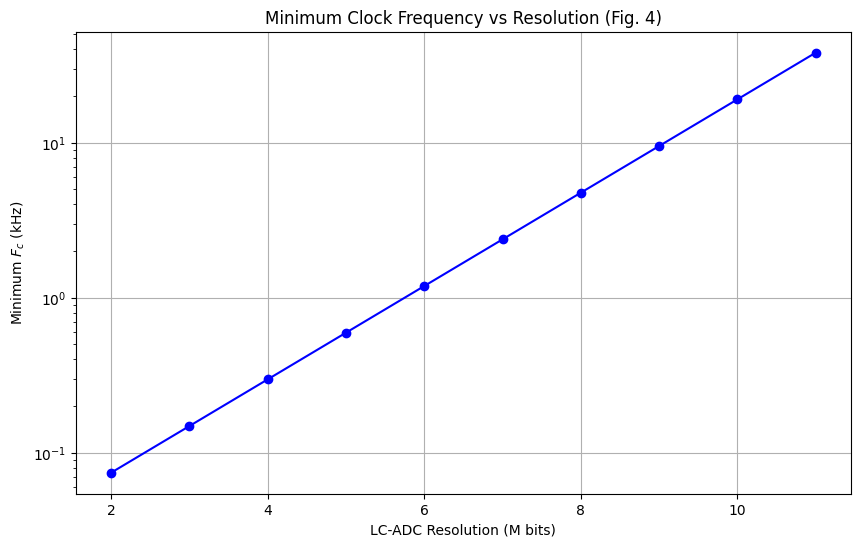

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

M_values = np.arange(2, 12)
Fc_values = [74.13, 148.26, 296.51, 593.03, 1186.06, 2372.12, 4744.24, 9488.49, 18976.97, 37953.94]

# Convert Fc_values to a NumPy array
Fc_values = np.array(Fc_values)

plt.figure(figsize=(10,6))
plt.plot(M_values, Fc_values/1e3, 'bo-')
plt.xlabel('LC-ADC Resolution (M bits)')
plt.ylabel('Minimum $F_c$ (kHz)')
plt.title('Minimum Clock Frequency vs Resolution (Fig. 4)')
plt.grid(True)
plt.yscale('log')
plt.show()


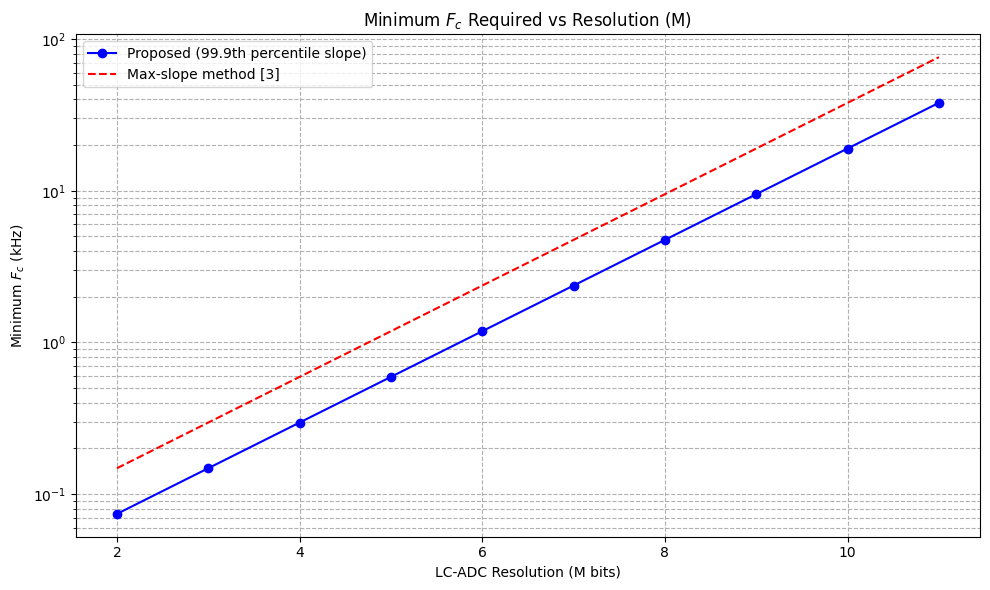

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Table I data (proposed method)
M = np.arange(2, 12)
Fc_proposed = np.array([74.13, 148.26, 296.51, 593.03, 1186.06, 2372.12, 4744.24, 9488.49, 18976.97, 37953.94])

# Max-slope method (from [3], roughly double the proposed values)
Fc_maxslope = Fc_proposed * 2  # Approximate, as per paper's description

plt.figure(figsize=(10,6))
plt.plot(M, Fc_proposed/1e3, 'bo-', label='Proposed (99.9th percentile slope)')
plt.plot(M, Fc_maxslope/1e3, 'r--', label='Max-slope method [3]')
plt.xlabel('LC-ADC Resolution (M bits)')
plt.ylabel('Minimum $F_c$ (kHz)')
plt.title('Minimum $F_c$ Required vs Resolution (M)')
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 95.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
